# 0.0. Importação

In [1]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import random
import warnings
import matplotlib.pyplot as plt
import pickle
import requests
from IPython.display import Image
import datetime
from scipy import stats

from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb

## 0.1. Funções auxiliares

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corrected = chi2 - ((k - 1)*(r - 1))/(n - 1)
    k_corrected = k - ((k - 1)**2)/(n - 1)
    r_corrected = r - ((r - 1)**2)/(n - 1)
    
    return np.sqrt((chi2_corrected/n) / (min(k_corrected - 1, r_corrected - 1)))

def mean_absolute_percentage_error(y, yhat):
    
    return np.mean(np.abs((y - yhat) / y ))

def ml_error(model_name, y, yhat):
    
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0])

## 0.2. Carregando os datasets

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Unindo os dataframes
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. Descrição dos dados

In [4]:
# Criando cópia do dataframe original
df1 = df_raw.copy()

## 1.1. Renomeando as colunas

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# Reescrevendo os nomes das colunas para seguir o padrão snakecase

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# Renomeando
df1.columns = cols_new

## 1.2. Dimensões dos dados

In [7]:
print( 'Number of rows: {}'.format(df1.shape[0]))
print( 'Number of rows: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of rows: 18


## 1.3. Tipos dos dados

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
# Ajustando o tipo de dado de date
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Buscando valores nulos

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Preenchendo valores nulos

In [11]:
# Primeiro, é preciso analizar cada uma das variáveis contendo NA

# competition_distance
## Hipótese: se é NA, talvez seja devido à ausência de competidores
## O que foi feito: CONSIDERAR UM VALOR EXTREMO COMO DISTANCIA
df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 100000 if math.isnan(x) else x )

# competition_open_since_month
## Hipotese: há duas grandes razões para valores NA: (i) a loja não apresenta competidores próximos ou (ii)
## (ii) a loja apresenta um competidor próximo, mas a data de abertura é desconhecida
## O que foi feito: CONSIDERAR O MESMO MÊS DE ABERTURA DA LOJA

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#Alternativa 
#df1.competition_open_since_month.fillna(df1.date.dt.month, inplace=True)

# competition_open_since_year
## Mesma ideia e solução descrita acima, com a diferença de ser o ano de abertura, invés do mês

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
#Alternative: 
#df1.competition_open_since_year.fillna(df1.date.dt.month, inplace=True)



# promo2
## Não possui NA

# promo2_since_week
## Hipotese: é possível que a presença de valores NA, sejam devido à ausência de promoções extendidas
## O que poderia ser feito: TODOS VALORES CONSIDERADOS COMO 0, DEVIDO À AUSÊNCIA DE EXTENSÃO DE PROMOÇÕES
## O que foi feito: CONSIDERADO A MESMA DATA
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].month if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


# promo2_since_year
## Mesma lógica descrita acima
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# promo_interval
## O problema aqui é a ausência de compreensão sobre como a variável foi inserida
## O que foi feito: (i) Analizar o intervalo da promoção; (ii) Avaliar se o mês se encontra no intervalo da promoção
## Se sim, (iii) aplicar o valor 1 e 0, caso contrário
## Assim, é mais fácil avaliar se uma venda se encontra em intervalo promocional

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', }

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )

df1.isna().sum()


store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Ajustando tipos dos dados

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
# Competição e promoções estão como float type, invés de int type

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descrição estatística

In [14]:
num_attributes = df1.select_dtypes( include=['int64','float64'])
#num_attributes = df1.loc[:,['store','day_of_week', 'sales', 'customers', 'open', 'promo', 'school_holiday', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'is_promo']]
cat_attributes = df1.select_dtypes( exclude=['int64','float64', 'datetime64[ns]'])
#cat_attributes = df1.loc[:, ['state_holiday', 'store_type', 'assortment', 'promo_interval', 'month_map']]
num_attributes.sample(5)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
242439,536,4,0,0,0,0,1,4700.0,9,2002,1,31,2013,0
751423,699,2,9237,1099,1,1,0,180.0,8,2013,1,5,2013,0
971212,833,1,2198,242,1,0,0,3290.0,12,1999,1,35,2010,0
489581,882,6,6307,866,1,0,0,30.0,4,2013,0,4,2014,0
668734,520,6,3029,282,1,0,0,6900.0,11,2013,1,40,2012,0


### 1.7.1. Atributos numéricos

In [15]:
# Tendência central - média, mediana

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - máximo, minimo, skew, kurtosis, desvio

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenando
n = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
                  
n.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

display(n)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,100000.0,99980.0,5675.712376,2330.0,9085.159292,4.637208,35.287543
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Atributos categóricos

In [16]:
# Contando os valores únicos de cada atributo categórico
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

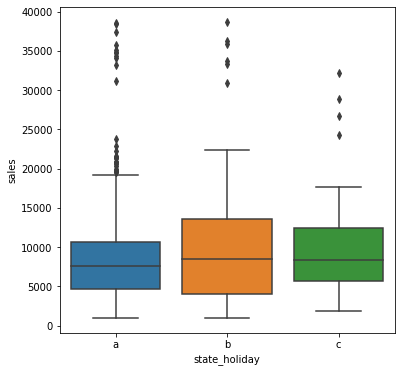

In [17]:
plt.figure(figsize=(6,6))
filter1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
sns.boxplot(x='state_holiday', y='sales', data=filter1)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

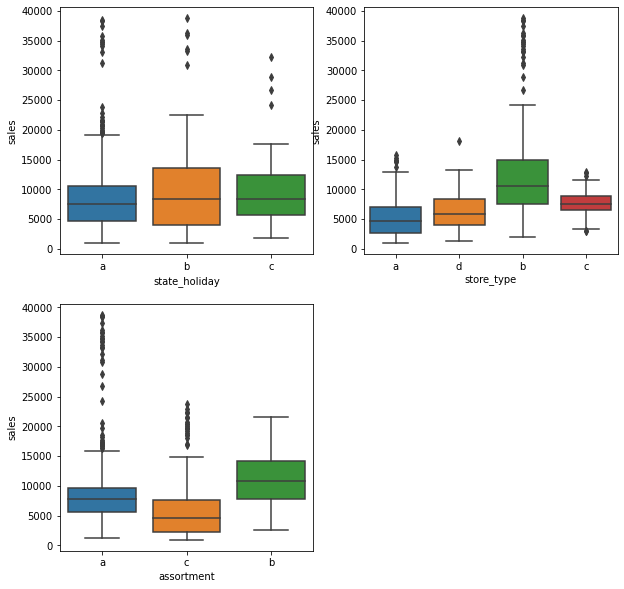

In [18]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
sns.boxplot(x='state_holiday', y='sales', data=filter1)

plt.subplot(2,2,2)
sns.boxplot(x='store_type', y='sales', data=filter1)

plt.subplot(2,2,3)
sns.boxplot(x='assortment', y='sales', data=filter1)

# 2.0. Feature engineering

In [19]:
df2 = df1.copy()

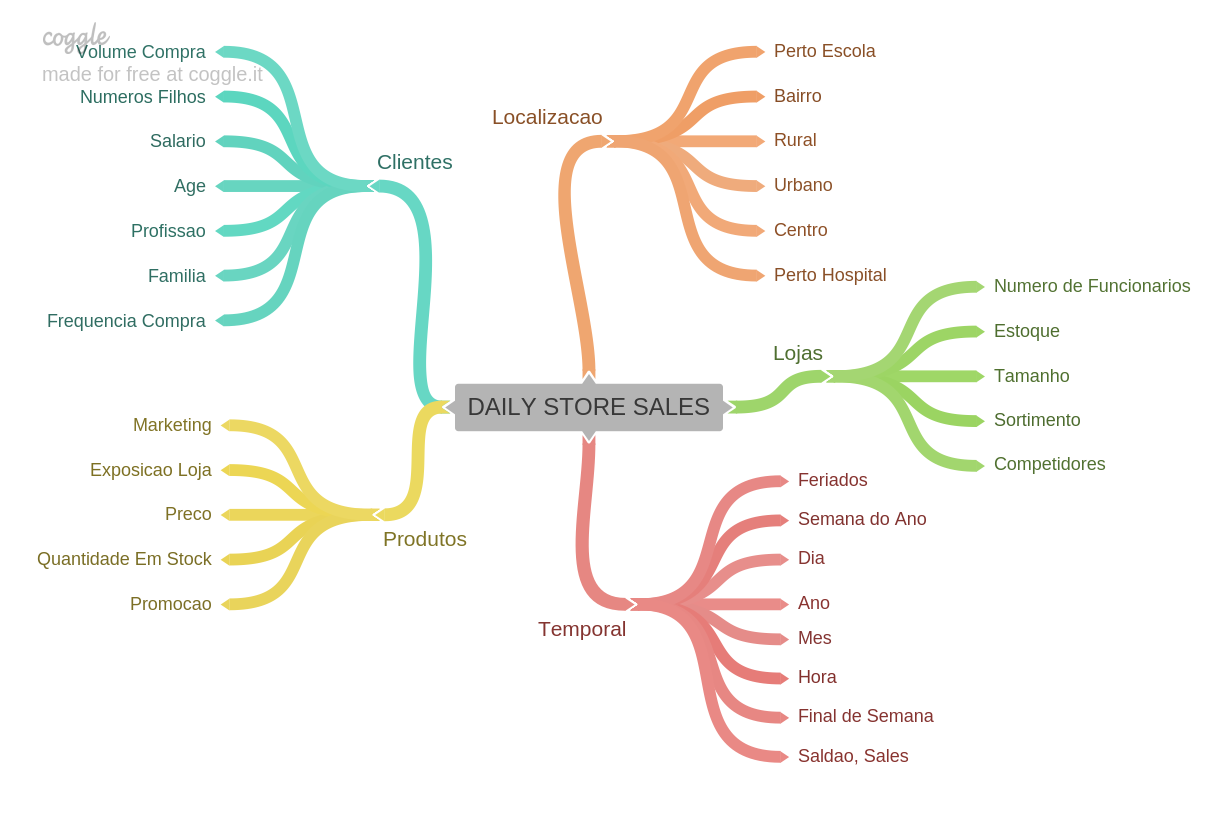

In [20]:
Image('img/MindMapHypothesis.png')

## 2.1. Mapa mental de hipóteses

### 2.1.1. Hipóteses sobre as lojas

**1.** Lojas com mais empregados **deveriam** vender mais.

**2.** Lojas com maiores estoques de produtos **deveriam** vender mais.

**3.** Lojas menores **deveriam** vender menos.

**4.** Lojas maiores **deveriam** vender mais.

**5.** Lojas com maior diversidade de produtos **deveriam** apresentar maiores vendas.

### 2.1.2. Hipóteses sobre os produtos

**1.** Lojas com maior investimento de marketing **deveriam** apresentar mais vendas.

**2.** Lojas com produtos de exposição maior **deveriam** vender mais destes produtos.

**3.** Lojas contendo produtos de menor ticket **deveriam** apresentar maiores vendas destes produtos.

**4.** Lojas com produtos em preço promocional por tempo prolongado **deveriam** apresentar maiores vendas destes produtos.

### 2.1.3. Hipóteses sobre o tempo

**1.** Lojas com mais feriados **deveriam** apresentar menos vendas.

**2.** Lojas que abriram há menos de 6 meses **deveriam** vender menos que lojas maduras.

**3.** Lojas que abrem aos feriados **deveriam** vender mais.

## 2.2. Priorização das hipóteses

As hipóteses devem ser priorizadas em termos da capacidade de resolução baseada nos dados disponíveis e capacidade de trazer mais insights para o time.

**1.** Lojas com maiores opções de produtos **deveriam** vender mais.

**2.** Lojas com competidores próximos **deveriam** apresentar menos vendas.

**3.** Lojas com competidores abertos há muito tempo **deveriam** apresentar mais vendas.


**4.** Lojas com mais promoções ativas **deveriam** vender mais. 

**5.** Lojas com promoções mais longas **deveriam** vender mais.

**6.** Lojas com promoções consecutivas **deveriam** apresentar mais vendas.


**7.** Lojas abertas durante o Natal **deveriam** apresentar mais vendas.

**8.** Vendas em mesmas lojas **deveriam** crescer ao longo dos anos.

**9.** Lojas **deveriam** vender mais no segundo semestre do ano.

**10.** Lojas **deveriam** vender mais após o décimo dia de cada mês.

**11.** Lojas **deveriam** vender menos ao longo dos finais de semana.

**12.** Lojas **deveriam** vender menos ao longo dos feriados escolares.

## 2.3. Feature Engineering

In [21]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#weekofyear
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competitionsince
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days ).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

# 3.0. Filtro das variáveis

In [22]:
df3 = df2.copy()

## 3.1. Filtro de linhas

In [23]:
# Filtrando por linhas contendo vendas maiores que 0 e lojas abertas
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtro de colunas

In [24]:
# Após filtro de linhas, removendo as colunas relacionadas ao número de clientes, se a loja está aberta ou fechada,
# e intervalo entre promoções.
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis = 1)

# 4.0. Análise exploratória de dados

In [25]:
df4 = df3.copy()

## 4.1. Análise univariada

### 4.1.1. Variável resposta - Vendas

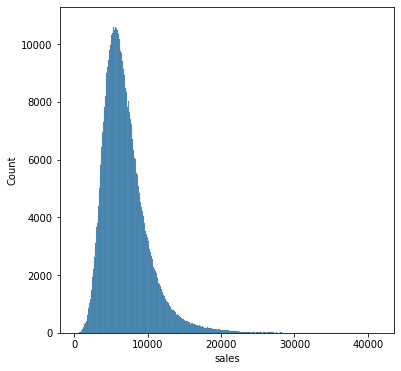

In [26]:
plt.figure(figsize=(6,6))
sns.histplot(df4['sales'])
plt.show()
# Quanto mais próximo à curva relacionada à variável resposta se aproximar à curva em formato de sino, melhor.
# Isso ocorre devido ao fato da maioria dos modelos presumirem a distribuição normal como premissa.

### 4.1.2. Variáveis numéricas

/home/pedro/.pyenv/versions/rossmanSales/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/pedro/.pyenv/versions/rossmanSales/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/pedro/.pyenv/versions/rossmanSales/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1,

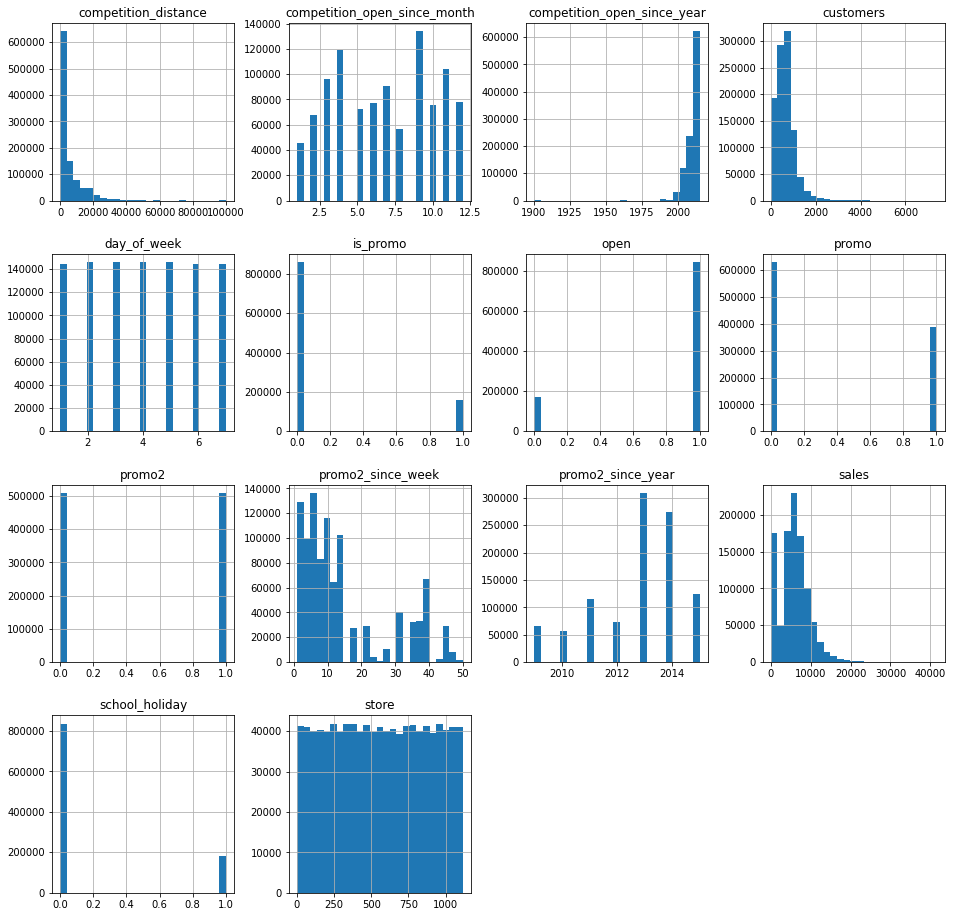

In [27]:
num_attributes.hist(bins=25, figsize=(16,16))

plt.show()

### 4.1.3 Variáveis categóricas

In [28]:
cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
672516,0,d,c,0,Nov
708769,0,d,c,0,Oct
766280,0,d,c,0,Aug
356868,0,a,c,"Jan,Apr,Jul,Oct",Aug
137195,0,a,c,"Jan,Apr,Jul,Oct",Mar


/home/pedro/.pyenv/versions/rossmanSales/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/pedro/.pyenv/versions/rossmanSales/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/pedro/.pyenv/versions/rossmanSales/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

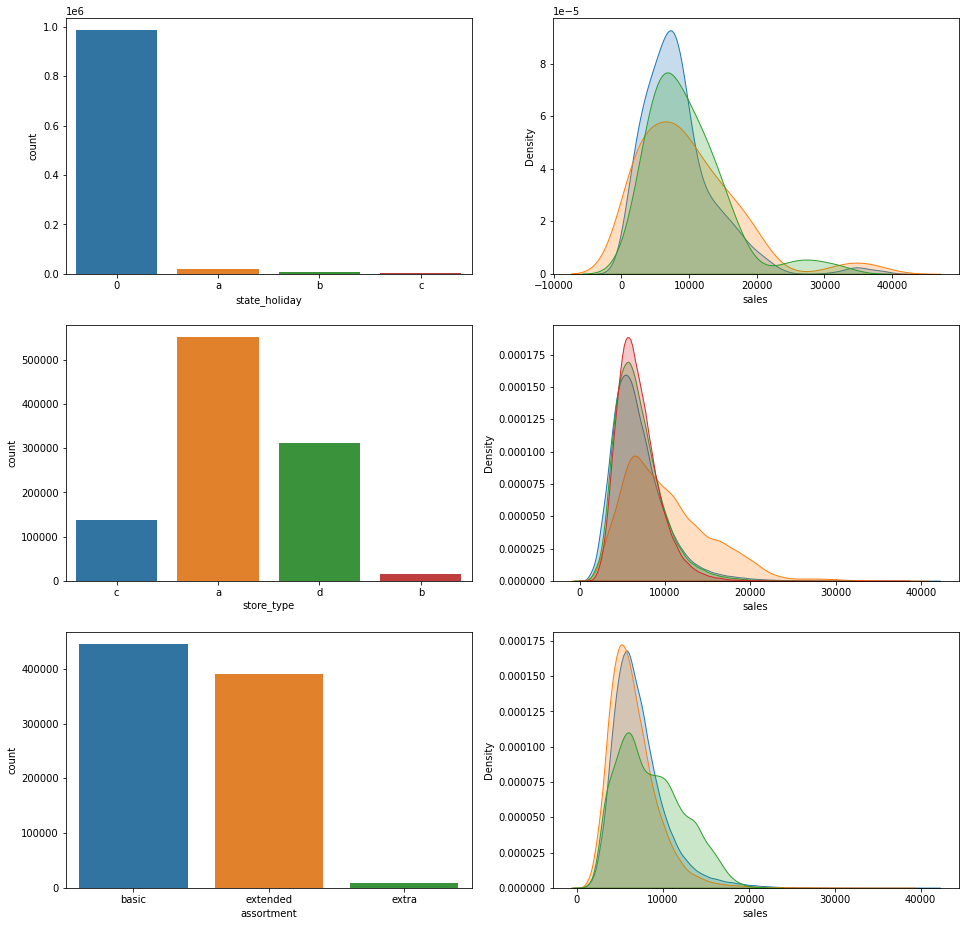

In [29]:
# State holiday
plt.figure(figsize=(16,16))
plt.subplot(3, 2, 1)
#a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(cat_attributes['state_holiday'], data=cat_attributes)

plt.subplot(3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True, data=df4)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True, data=df4)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True, data=df4)

# Store type
plt.subplot(3, 2, 3)
sns.countplot(cat_attributes['store_type'], data=cat_attributes)

plt.subplot(3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True, data=df4)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True, data=df4)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True, data=df4)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True, data=df4)

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True, data=df4)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True, data=df4)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True, data=df4)

plt.show()

## 4.2. Análise bivariada

### Hipótese **1.** Lojas com maior diversidade de produtos **deveriam** vender mais

/home/pedro/.pyenv/versions/rossmanSales/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


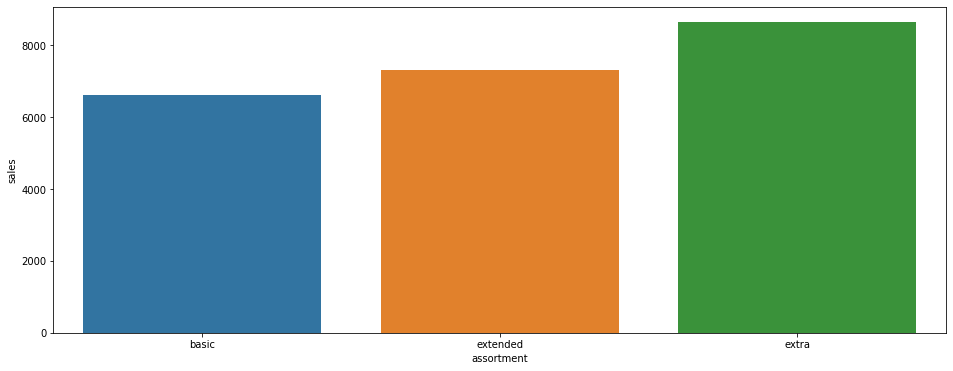

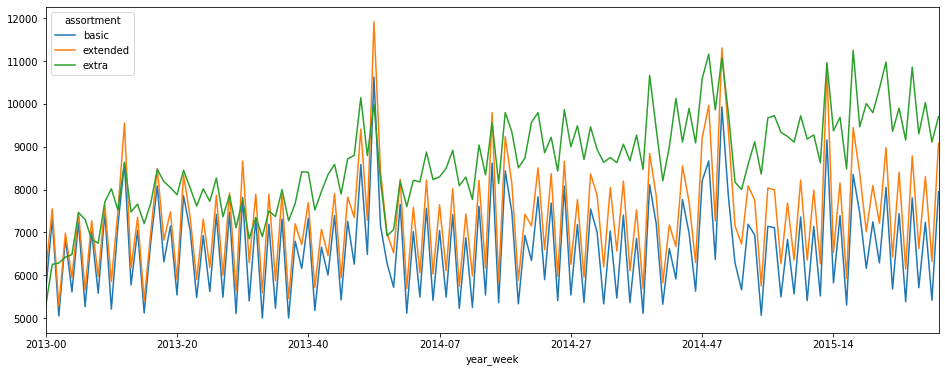

In [30]:
plt.figure(figsize=(16,6))
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data= aux1);

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(16,6))
#sns.barplot(x='assortment', y='sales', data= aux2);

plt.show()

 **Verdadeiro** Os resultados de vendas médias para lojas com maior diversidade de produtos, **vendem mais** que lojas com menos diversidade de produtos.

### Hipótese **2.** Lojas com competidores mais próximos **deveriam** vender menos

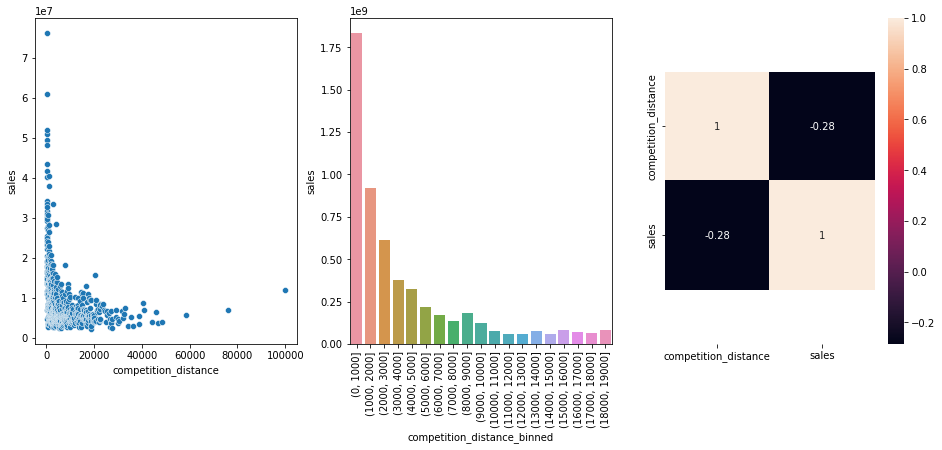

In [31]:
plt.figure(figsize=(16,6))

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot (1, 3, 1)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
#sns.barplot(x='competition_distance_binned', y='sales', data= aux1);
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data= aux2);
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

**Falso** lojas com competidores mais próximos, tende a **vender mais** que aquelas com competidores distantes

### Hipótese **3.** Lojas com competidores há mais tempo devem ter mais vendas

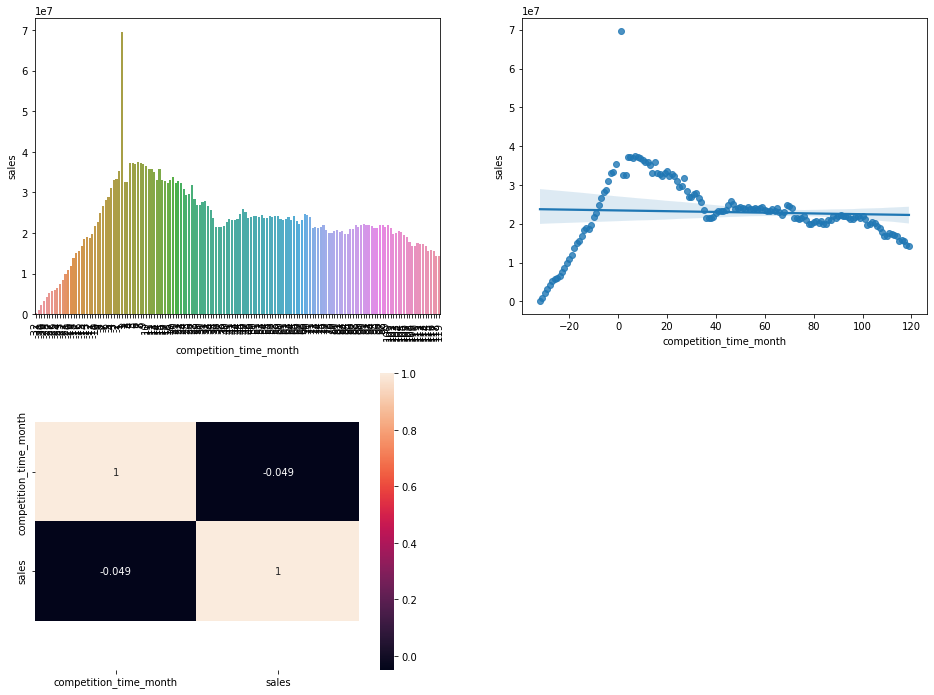

In [32]:
plt.figure(figsize=(16,12))

plt.subplot(2, 2, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux4 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0) ]
sns.barplot(x='competition_time_month', y='sales', data=aux4)
plt.xticks(rotation=90);

plt.subplot(2, 2, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux4)

plt.subplot(2, 2, 3)
x = sns.heatmap(aux4.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

**Falso** lojas com competidores a mais tempo **vendem menos**. Entretanto, observa-se um comportamento diferente das vendas antes e depois da chegada de um competidor.

## 4.3. Análise multivariada

### 4.3.1. Atributos numéricos

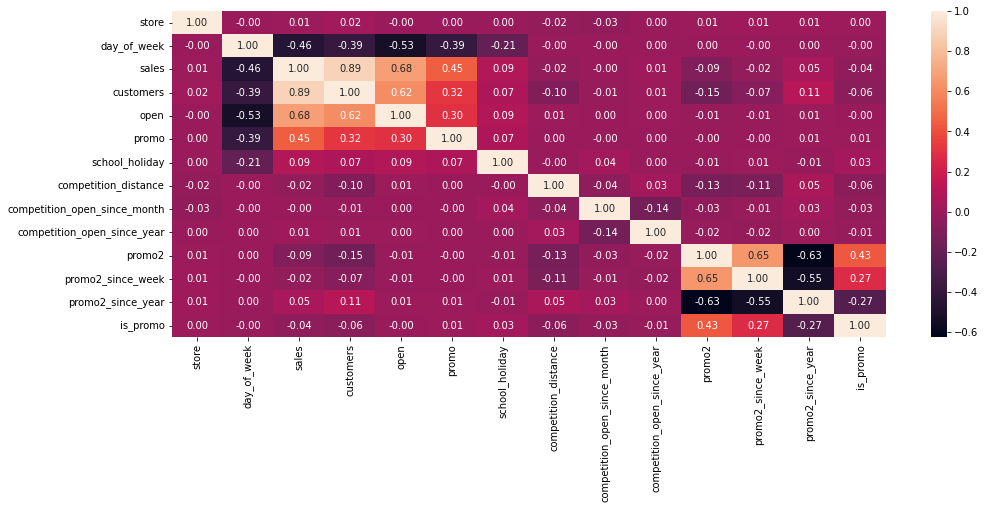

In [33]:
plt.figure(figsize=(16,6))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True, fmt='.2f')
plt.show()

### 4.3.2. Atributos categóricos

In [34]:
categorical = df4.select_dtypes(include='object')
categorical.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [35]:
cm = pd.crosstab(categorical['state_holiday'], categorical['store_type']).values

In [36]:
a1 = cramer_v(categorical['state_holiday'], categorical['state_holiday'])
a2 = cramer_v(categorical['state_holiday'], categorical['store_type'])
a3 = cramer_v(categorical['state_holiday'], categorical['assortment'])

a4 = cramer_v(categorical['store_type'], categorical['state_holiday'])
a5 = cramer_v(categorical['store_type'], categorical['store_type'])
a6 = cramer_v(categorical['store_type'], categorical['assortment'])

a7 = cramer_v(categorical['assortment'], categorical['state_holiday'])
a8 = cramer_v(categorical['assortment'], categorical['store_type'])
a9 = cramer_v(categorical['assortment'], categorical['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9] })

d = d.set_index(d.columns)
display(d.head())

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


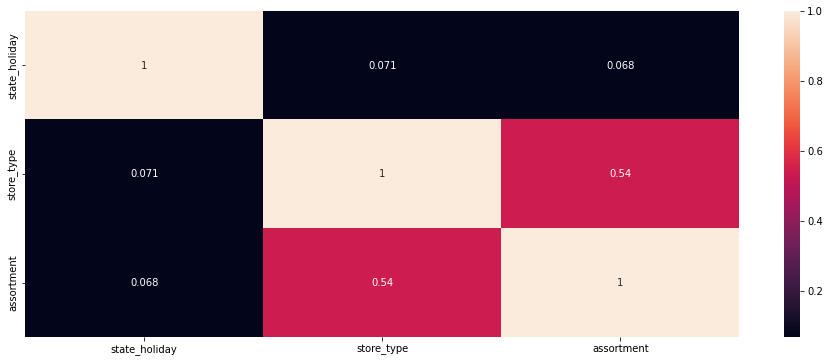

In [37]:
plt.figure(figsize=(16,6))
sns.heatmap(d, annot=True)
plt.show()

# 5.0. Preparação dos dados

In [38]:
df5 = df4.copy()

## 5.1. Normalização dos dados

## 5.2. Data rescaling

In [39]:
a = df5.select_dtypes(include=['int64','float64'])

# Antes de determinar qual método de reescala foi utilizado para cada variável, foi estudado quais delas apresentam outliers

# competition distance
rs = RobustScaler()
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump(rs, open('parameters/competition_distance_scaler.pkl','wb'))

# competition time month
mms = MinMaxScaler()
df5['competition_time_month'] = mms.fit_transform( df5[['competition_time_month']].values )
pickle.dump(mms, open('parameters/time_month_scaler.pkl','wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump(mms, open('parameters/year_scaler.pkl','wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump(mms, open('parameters/promo_time_week_scaler.pkl','wb'))

#sns.distplot(df5['competition_distance'])

## 5.3. Transformação dos dados

### 5.3.1. Encoding

In [40]:
# state holiday - One hot encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])
df5.head()


,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,...,31,2015-30,2008-09-01,0.080612,2015-02-09,0.341686,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,...,31,2015-30,2007-11-01,0.087561,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,...,31,2015-30,2006-12-01,0.095205,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,c,extended,-0.275806,9,...,31,2015-30,2009-09-01,0.071577,2015-02-09,0.341686,0,0,0,1
4,5,5,2015-07-31,4822,1,1,a,basic,4.448387,4,...,31,2015-30,2015-04-01,0.025017,2015-02-09,0.341686,0,0,0,1


In [41]:
# store type - Label Encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameters/enconding_store_type.pkl','wb'))

# assortment - Ordinal Encoder
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.080612,2015-02-09,0.341686,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,0.087561,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,0.095205,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.071577,2015-02-09,0.341686,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,0.025017,2015-02-09,0.341686,0,0,0,1


### 5.3.2. Transformação da variável resposta

/home/pedro/.pyenv/versions/rossmanSales/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


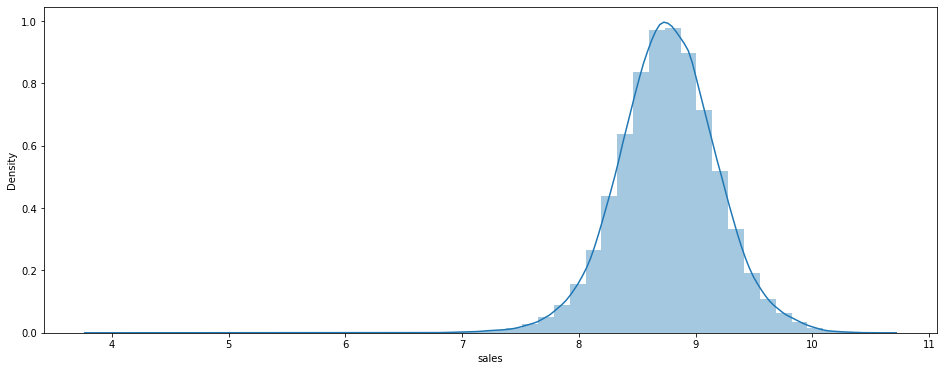

In [42]:
df5['sales'] = np.log1p( df5['sales'])

plt.figure(figsize=(16,6))
sns.distplot(df5['sales'])
plt.show()

### 5.3.1. Transformção de natureza (atributos temporais)

In [43]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2 * np.pi/7)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2 * np.pi/30)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2 * np.pi/12)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2 * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2 * np.pi/52)))


# 6.0. Seleção de features

In [44]:
df6 = df5.copy()

## 6.1. Divisão dos dados

In [45]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']

df6 = df6.drop(cols_drop, axis=1)

In [46]:
# Preparando os dados para treino e teste
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [47]:
# Dataset para treino
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# Dataset para teste
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print('Training min Date: {}'.format(x_train['date'].min()))
print('Training max Date: {}'.format(x_train['date'].max()))

print('Test min Date: {}'.format(x_test['date'].min()))
print('Test max Date: {}'.format(x_test['date'].max()))

Training min Date: 2013-01-01 00:00:00
Training max Date: 2015-06-18 00:00:00
Test min Date: 2015-06-19 00:00:00
Test max Date: 2015-07-31 00:00:00


## 6.2. Seletor de features - Boruta

Devido ao elevado número de features presentes nos dados para serem usadas para a criação do regressor de previsão de vendas, foi utilizado o algoritmo Boruta para ajudar. O Boruta utiliza um regressor baseado em árvores que ajuda a identificar as features/combinação de features que resultam no maior ganho de informação possível e fornece estes resultados em ordem de importância.

Com isso, pode-se analisar os resultados do Boruta e fazer uma avaliação sobre a exclusão ou não de uma determinada feature.

In [48]:
# Treinando e testando o Boruta para seleção de features
x_train_n = x_train.drop(['date','sales'], axis=1).values
y_train_n = y_train.values.ravel()


# Definindo RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(x_train_n,y_train_n)

### 6.2.1. Melhores features de acordo com o Boruta

In [49]:
#cols_selected = boruta.support_.tolist()

# Melhores atributos
#x_train_fs = x_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# Não selecionados pelo Boruta
#cols_not_selected_boruta = list(np.setdiff1d( x_train_fs.columns, cols_selected_boruta))

### 6.3. Seleção manual de features a partir do Boruta

In [50]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'day_sin',
                        'day_cos',
                        'month_cos',
                        'month_sin',
                        'week_of_year_cos',
                        'week_of_year_sin']

# month_sin e week_of_year_sin adicionados manualmente. Todos os outros atributos foram selecionados pelo Boruta.

# Colunas a serem adicionadas
feat_to_add = ['date','sales']

# Atributos finais
#cols_selected_boruta.extend(feat_to_add)

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7. Algoritmos de machine learning

In [51]:
X_train = x_train[cols_selected_boruta]
X_test = x_test[cols_selected_boruta]

## 7.1. Modelo de média

O modelo de média representa um benchmark para os modelos de machine learning e serviria para informar o quanto a mais de precisão está sendo ganho ao invés de simplesmente estimar uma média para cada loja e extrapolar isto para o futuro.

In [52]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')

yhat_baseline = aux1['predictions']

# Performance
baseline_error = ml_error('Average_Model', np.expm1(y_test), np.expm1(yhat_baseline) )

display(baseline_error)

,Model Name,MAE,MAPE,RMSE
0,Average_Model,1354.800353,0.455051,1835.135542


## 7.2. Regressão linear

Os modelos mais simples a serem avaliados representam modelos de regressão linear, com ou sem regularização.

In [53]:
# Modelo
lr = LinearRegression().fit(X_train, y_train)

# Previsão
yhat_lr = lr.predict(X_test)

# Performance
lr_error = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
display(lr_error)

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1872.265525,0.295371,2666.035764


## 7.3. Regressão linear regularizada (LASSO)

In [54]:
# Modelo
lrr = Lasso(alpha=0.001).fit(X_train, y_train)

# Previsão
yhat_lrr = lrr.predict(X_test)

# Performance
lrr_error = ml_error('LASSO', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_error

,Model Name,MAE,MAPE,RMSE
0,LASSO,1873.163753,0.288561,2696.356099


Uma comparação rápida entre os modelos lineares e o modelo de média, mostram que aqueles apresentam um resultado pior. Uma das razões da ocorrência deste fenômeno, pode ser causada pela presença de não linearidades no problema, afetando a acurácia dos modelos lineares.

## 7.4. Algoritmo Random forest para regressão

In [55]:
# Modelo
#rf = RandomForestRegressor(n_estimators=75, n_jobs=-1, random_state=42).fit(X_train, y_train)

# Previsão
#yhat_rf = rf.predict(X_test)

# Performance
#rf_error = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_rf) )
#display(rf_error)

## 7.5. Algoritmo XGBoost para regressão

In [74]:
# Modelo
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9,
                             n_jobs=-1, random_state=42).fit(X_train, y_train)

# Previsão
yhat_xgb = model_xgb.predict(X_test)

# Performance
xgb_error = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb) )
display(xgb_error)

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.629635,0.949504,7330.71217


Os resultados preliminares tanto com o modelo XGBoost quanto o modelo Random Forest para regressão apresentaram métricas de erro inferiores tanto ao modelo de média, quanto aos modelos lineares, indicando a capacidade destes modelos em capturar as não linearidades do problema.

## 7.6. Cross-time validation

Para problemas envolvendo séries temporais, é necessário realizar a validação cruzada do modelo ao longo da série, ao dividir os dados em janelas e ir treinando e testando os modelos para janelas cada vez maiores. Para facilitar a realização da validação cruzada ao longo do tempo, foi criada uma função para a realização deste processo.

In [57]:
x_training = x_train[cols_selected_boruta_full]

def cross_validation(x_training, kfold, model_name, model):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1,kfold+1)):

        print('KFold: {}'.format(k))

        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training
        ytraining = training['sales']
        xtraining = training.drop(['date','sales'], axis=1)

        # validation
        yvalidation = validation['sales']
        xvalidation = validation.drop(['date','sales'], axis=1)

        # model
        m = model.fit(xtraining,ytraining)

        #prediction
        yhat = m.predict(xvalidation)
        #print(validation.head())
        # performance
        error = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        mae_list.append(error['MAE'])
        mape_list.append(error['MAPE'])
        rmse_list.append(error['RMSE'])

        print('Validation start date: {}'.format(validation_start_date))    
        print('Validation end date:   {}'.format(validation_end_date)) 

    return pd.DataFrame({'Model name': model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
                         }, index=[0])

### 7.6.1. Validação do modelo de regressão linear

In [58]:
lr_validation = cross_validation(x_training, 5, 'Linear regression', LinearRegression())
display(lr_validation)

KFold: 5
Validation start date: 2014-11-20 00:00:00
Validation end date:   2015-01-01 00:00:00
KFold: 4
Validation start date: 2015-01-01 00:00:00
Validation end date:   2015-02-12 00:00:00
KFold: 3
Validation start date: 2015-02-12 00:00:00
Validation end date:   2015-03-26 00:00:00
KFold: 2
Validation start date: 2015-03-26 00:00:00
Validation end date:   2015-05-07 00:00:00
KFold: 1
Validation start date: 2015-05-07 00:00:00
Validation end date:   2015-06-18 00:00:00


,Model name,MAE CV,MAPE CV,RMSE CV
0,Linear regression,2094.79 +/- 301.94,0.3 +/- 0.02,2960.98 +/- 486.59


### 7.6.2. Validação do modelo de regressão linear regularizado

In [59]:
lasso_validation = cross_validation(x_training, 5, 'LASSO', Lasso(alpha=0.001))
display(lasso_validation)

KFold: 5
Validation start date: 2014-11-20 00:00:00
Validation end date:   2015-01-01 00:00:00
KFold: 4
Validation start date: 2015-01-01 00:00:00
Validation end date:   2015-02-12 00:00:00
KFold: 3
Validation start date: 2015-02-12 00:00:00
Validation end date:   2015-03-26 00:00:00
KFold: 2
Validation start date: 2015-03-26 00:00:00
Validation end date:   2015-05-07 00:00:00
KFold: 1
Validation start date: 2015-05-07 00:00:00
Validation end date:   2015-06-18 00:00:00


,Model name,MAE CV,MAPE CV,RMSE CV
0,LASSO,2102.23 +/- 340.97,0.3 +/- 0.02,3003.5 +/- 525.39


### 7.6.3. Validação do modelo de random forest

In [60]:
#model_random_forest = RandomForestRegressor(n_estimators=75, n_jobs=-1, random_state=42)
#random_forest_validation = cross_validation(x_training, 5, 'Random Forest', model_random_forest)
#display(random_forest_validation)

### 7.6.4. Validação do modelo de XGBoost

In [75]:
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9,
                             n_jobs=-1, random_state=42)

xgboost_validation = cross_validation(x_training, 5, 'XGBoost model', xgboost_model)
display(xgboost_validation)

KFold: 5
Validation start date: 2014-11-20 00:00:00
Validation end date:   2015-01-01 00:00:00
KFold: 4
Validation start date: 2015-01-01 00:00:00
Validation end date:   2015-02-12 00:00:00
KFold: 3
Validation start date: 2015-02-12 00:00:00
Validation end date:   2015-03-26 00:00:00
KFold: 2
Validation start date: 2015-03-26 00:00:00
Validation end date:   2015-05-07 00:00:00
KFold: 1
Validation start date: 2015-05-07 00:00:00
Validation end date:   2015-06-18 00:00:00


,Model name,MAE CV,MAPE CV,RMSE CV
0,XGBoost model,7048.97 +/- 588.66,0.95 +/- 0.0,7714.93 +/- 689.75


## 7.7. Comparativo entre a performance dos modelos

In [76]:
#model_results = pd.concat([lr_validation, lasso_validation, random_forest_validation, xgboost_validation])
model_results = pd.concat([lr_validation, lasso_validation, xgboost_validation])
model_results

,Model name,MAE CV,MAPE CV,RMSE CV
0,Linear regression,2094.79 +/- 301.94,0.3 +/- 0.02,2960.98 +/- 486.59
0,LASSO,2102.23 +/- 340.97,0.3 +/- 0.02,3003.5 +/- 525.39
0,XGBoost model,7048.97 +/- 588.66,0.95 +/- 0.0,7714.93 +/- 689.75


Entre os diferentes modelos, observa-se uma performance melhor para os modelos de Random Forest e XGBoost, em relação aos modelos lineares. Para o modelo Random Forest, observa-se uma média da métrica de erro MAE menor em comparação ao XGBoost. No entanto, o XGBoost apresenta uma dispersão de resultados menor em relação às métricas de erro e, por isso, será escolhido como modelo final.

# 8. Fine tuning do modelo

## 8.1. Random Search

Para a realização do fine tuning do modelo, foi utilizado o método de busca aleatória em ao longo de listas com variações nos hiperparâmetros.

In [78]:
#warnings.filterwarnings('ignore')


param = {'n_estimators':[150, 250, 300, 350, 400],
         'eta':[0.005, 0.01, 0.03, 0.05],
         'max_depth':[3, 5, 9],
         'subsample':[0.1, 0.5, 0.7],
         'colsample_bytree':[0.3, 0.7, 0.9],
         'min_child_weight':[3, 8, 15]
        }

MAX_EVAL = 8

# Modelo

final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    
    hp = { k: random.sample(v,1)[0] for k, v in param.items()}
    
    print(hp)

    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'],
                                 n_jobs=-1, random_state=42)


    # Performance
    result = cross_validation(x_training, 5, 'XGBoost model', model_xgb)
    final_result = pd.concat([final_result, result])
    
final_result

{'n_estimators': 400, 'eta': 0.005, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}
KFold: 5
Validation start date: 2014-11-20 00:00:00
Validation end date:   2015-01-01 00:00:00
KFold: 4
Validation start date: 2015-01-01 00:00:00
Validation end date:   2015-02-12 00:00:00
KFold: 3
Validation start date: 2015-02-12 00:00:00
Validation end date:   2015-03-26 00:00:00
KFold: 2
Validation start date: 2015-03-26 00:00:00
Validation end date:   2015-05-07 00:00:00
KFold: 1
Validation start date: 2015-05-07 00:00:00
Validation end date:   2015-06-18 00:00:00
{'n_estimators': 250, 'eta': 0.005, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
KFold: 5
Validation start date: 2014-11-20 00:00:00
Validation end date:   2015-01-01 00:00:00
KFold: 4
Validation start date: 2015-01-01 00:00:00
Validation end date:   2015-02-12 00:00:00
KFold: 3
Validation start date: 2015-02-12 00:00:00
Validation end date:   2015-03-26 00:00:00
KFo

,Model name,MAE CV,MAPE CV,RMSE CV
0,XGBoost model,5202.16 +/- 517.67,0.67 +/- 0.01,5988.0 +/- 623.09
0,XGBoost model,6756.1 +/- 586.2,0.9 +/- 0.0,7444.69 +/- 688.02
0,XGBoost model,1367.09 +/- 148.05,0.19 +/- 0.01,1970.77 +/- 191.03
0,XGBoost model,3057.9 +/- 408.07,0.36 +/- 0.02,4027.35 +/- 517.66
0,XGBoost model,1703.9 +/- 180.11,0.24 +/- 0.01,2445.22 +/- 238.98
0,XGBoost model,1163.4 +/- 176.36,0.16 +/- 0.02,1681.26 +/- 238.39
0,XGBoost model,6328.66 +/- 580.35,0.84 +/- 0.01,7046.85 +/- 683.58
0,XGBoost model,1734.75 +/- 203.29,0.24 +/- 0.01,2499.6 +/- 286.31


## 8.2. Modelo final

In [86]:
param_tuned = {'n_estimators':400,
         'eta':0.03,
         'max_depth':9,
         'subsample':0.1,
         'colsample_bytree':0.9,
         'min_child_weight':3
        }

In [87]:
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=param_tuned['n_estimators'],
                             eta=param_tuned['eta'],
                             max_depth=param_tuned['max_depth'],
                             subsample=param_tuned['subsample'],
                             colsample_bytree=param_tuned['colsample_bytree'],
                             min_child_weight=param_tuned['min_child_weight'],
                             n_jobs=-1, random_state=42).fit(X_train, y_train)


                            
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(X_test)

# performance
xgb_error_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
xgb_error_tuned


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,891.835469,0.13188,1292.776545


# 9. Interpretação dos erros do modelo

In [88]:
df9 = x_test[cols_selected_boruta_full]

# Reescala
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

/home/pedro/.pyenv/versions/rossmanSales/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/pedro/.pyenv/versions/rossmanSales/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## 9.1. Performance das lojas

Os resultados de previsão do modelo são então utilizados para prever o total de vendas para as próximas 6 semanas. A métrica de erro médio absoluto percentual é então utilizada para trazer o valor previsto de venda e um intervalo a ser considerado como o pior e melhor cenários.

In [89]:
# sum of predictions

df9_1 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner',on='store')
df9_2 = pd.merge(df9_1,df9_aux3, how='inner',on='store')

# scenarios
df9_2['worst_scenario'] = df9_2['predictions'] * ( 1 - df9_2['MAPE'])
df9_2['best_scenario'] = df9_2['predictions'] * ( 1 +  df9_2['MAPE'])

# ordering columns

df9_2 = df9_2[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

df9_2.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,175078.609375,158225.514785,191931.703965,412.135115,0.096260
1,2,182902.796875,164518.543588,201287.050162,504.500264,0.100514
2,3,256415.390625,237961.368177,274869.413073,530.085647,0.071969
3,4,337076.937500,305916.038328,368237.836672,958.066657,0.092444
4,5,180418.406250,160109.468929,200727.343571,517.460786,0.112566


## 9.2. Performance total

In [90]:
df9_3 = df9_2[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenarios', 0:'Values'})

df9_3['Values'] = df9_3['Values'].map('${:,.2f}'.format)

df9_3.head()

,Scenarios,Values
0,predictions,"$280,751,274.27"
1,worst_scenario,"$244,345,771.58"
2,best_scenario,"$317,156,776.95"


Através dos resultados da performance total do modelo, observa-se que ao longo das próximas 6 semanas os diretores e CEO podem esperar uma receita de aproximadamente \\$280 milhões de dólares para o plano de expansão, dentro de uma faixa de \\$244 milhões de dólares (pior cenário) e \\$317 milhões (melhor cenário).

## 9.3. Performance do modelo de machine learning

In [91]:
df9['errors'] = df9['predictions'] - df9['sales']
df9['error_rate'] = df9['predictions'] / df9['sales']                                       

/home/pedro/.pyenv/versions/rossmanSales/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/pedro/.pyenv/versions/rossmanSales/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/home/pedro/.pyenv/versions/rossmanSales/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/pedro/.pyenv/versions/rossmanSales/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


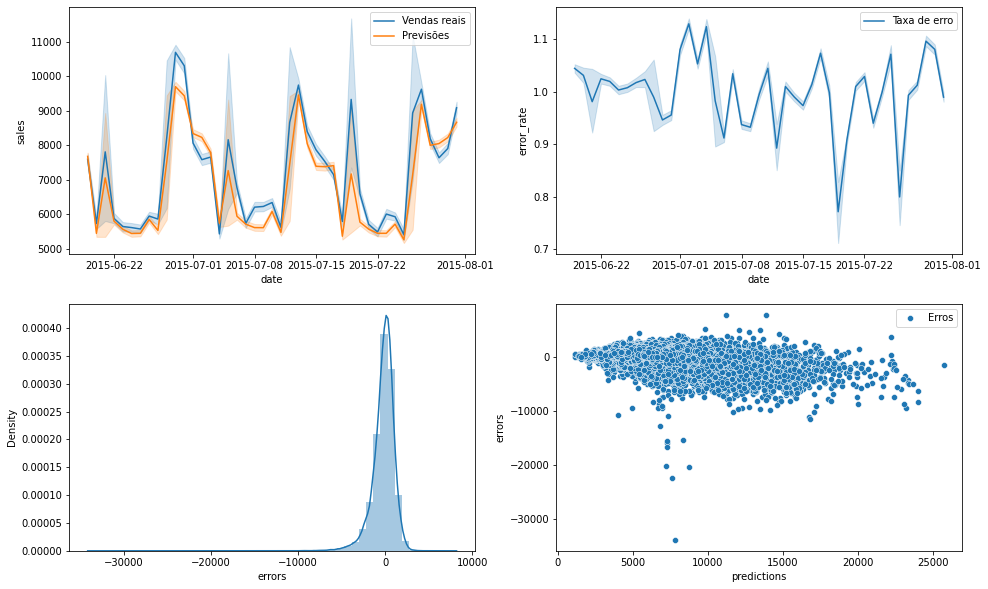

In [92]:
fig = plt.figure(figsize=(16,10))

plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales', data=df9, label='Vendas reais')
sns.lineplot(x='date',y='predictions', data=df9, label='Previsões')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate', data=df9, label='Taxa de erro')

plt.subplot(2,2,3)
sns.distplot(df9['errors'], label='Distribuição dos erros')


plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['errors'], label='Erros')

plt.savefig('img/model_results.png', dpi=fig.dpi)

plt.show()

Observando uma visão mais geral em relação ao valores de vendas, as previsões do modelo e seus respectivos erros, observa-se, através da primeira imagem, que o modelo apresenta uma tendência maior de prever valores menores que os reais.

Dessa forma, pode-se interpretar que o modelo apresenta uma tendência mais conservadora em

# 10. Deploy do modelo em produção

Para deploy do modelo em produção, o primeiro passo a ser realizado é salvar o modelo treinado no formato pkl, através da biblioteca pickle. O principal do objetivo disto é possibilitar o rápido carregamento futuro do modelo em memória no ambiente de produção.

In [93]:
pickle.dump(model_xgb_tuned, open('model/model_xgb_tuned.pkl','wb'))

## 10.1. Criação da classe Rossman

A criação da classe Rossman, representa todo o processo de limpeza e transformação dos dados, conforme foi realizado anteriormente. O objetivo desta etapa é de simplificar e abstrair parte do processo realizado na API a ser utilizada em produção.

In [94]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossman(object):
    
    def __init__(self):
        
        self.home_path = '/home/pedro/Documents/repos/1-Rossman-Sales-Prediction/'
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parameters/competition_distance_scaler.pkl','rb'))
        self.time_month_scaler           = pickle.load(open(self.home_path + 'parameters/time_month_scaler.pkl','rb'))
        self.year_scaler                 = pickle.load(open(self.home_path + 'parameters/year_scaler.pkl','rb'))
        self.promo_time_week_scaler      = pickle.load(open(self.home_path + 'parameters/promo_time_week_scaler.pkl','rb'))
        self_encoding_store_type         = pickle.load(open(self.home_path + 'parameters/enconding_store_type.pkl','rb'))        

            
    def data_cleaning(self,df1):

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        # Changing write pattern to snakecase

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # Renaming
        df1.columns = cols_new

        ## 1.3. Data Types

        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5. Fillout NA

        # First, we must analyze what every variable and data with NA values

        # competition_distance
        ## Assumption: if it is NA, maybe it is because the store doesnt have an near competitor
        ## What has been done: CONSIDER AN EXTREME DISTANT RANGE FROM NEAR COMPETITOR

        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 100000 if math.isnan(x) else x )

        # competition_open_since_month
        ## Assumption: there are two main reasons that this data is NA: (i) the store doesnt have a near competitor or
        ## (ii) the store has an near competitor, but it the opening data is unknown, either it is older than the store or data is unavailable
        ## What has been done: CONSIDER THE SAME MONTH THAT THE STORE HAS BEEN OPEN (because it maybe older than the store)

        # Error: EDIT Solved
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
        #Alternative: 
        #df1.competition_open_since_month.fillna(df1.date.dt.month, inplace=True)

        # competition_open_since_year
        ## Same ideia from variable above

        #Error: EDIT: Solved
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
        #Alternative: 
        #df1.competition_open_since_year.fillna(df1.date.dt.month, inplace=True)



        # promo2
        ## Doesnt have any NA

        # promo2_since_week
        ## Assumption: it is possible that the NA values are due to lack of participation/extension of any promotions.
        ## What I think should have been done: ALL NA VALUES ARE CONSIDERED "0", AS THE STORE IS NOT EXTENDING PROMOTIONS
        ## What has actually been done: CONSIDER THE SAME VALUE AS THE DATE
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].month if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


        # promo2_since_year
        ## Same logic as above
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


        # promo_interval
        ## The problem here is that, it is hard to understand the way it has been inserted.
        ## What has been done: (i) Analyze the interval of the promo; (ii) Check if sale month is in promo_interval
        ## if it is, (iii) apply value 1 to new column is_promo, else 0.
        ## This way, it will be easy to check if sale is inside a promotion interval.

        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', }

        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )

        df1.isna().sum()


        df1.sample(5).T

        ## 1.6. Change Types

        # Competion and promos since are portrayed as float types, while it should be int type.

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
    
        return df1
    
    
    def feature_engineering(self, df2):

        #year
        df2['year'] = df2['date'].dt.year

        #month
        df2['month'] = df2['date'].dt.month

        #day
        df2['day'] = df2['date'].dt.day

        #weekofyear
        df2['week_of_year'] = df2['date'].dt.weekofyear

        #year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        #competitionsince
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7) )
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days ).astype(int)

        #assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

        # 3.0. VARIABLE FILTERING

        ## 3.1. Line Filtering

        df2 = df2[(df2['open'] != 0)]

        ## 3.2. Column FIltering

        cols_drop = ['open', 'promo_interval', 'month_map']

        df2 = df2.drop(cols_drop, axis = 1)
        
        return df2
    
    def data_preparation(self, df5):

        ## 5.1. Data normalization

        ## 5.2. Data rescaling

        # Before choosing which rescale method will be used, we must know which variables have outliers.
        #sns.boxplot(df5['competition_distance'])

        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        # competition time month
        df5['competition_time_month'] = self.time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )

        #sns.distplot(df5['competition_distance'])

        ## 5.3. Data transformation

        ### 5.3.1. Encoding

        #df5.select_dtypes('object')

        # state holiday - One hot encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])


        # store type - Label Encoder
        le = LabelEncoder()
        df5['store_type'] = self_encoding_store_type.fit_transform(df5['store_type'])


        # assortment - Ordinal Encoder
        assortment_dict = {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)


        ### 5.3.1. Nature Transformation

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2 * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2 * np.pi/7)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2 * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2 * np.pi/30)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2 * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2 * np.pi/12)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2 * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2 * np.pi/52)))
        
        cols_selected = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'day_sin',
                        'day_cos',
                        'month_cos',
                        'month_sin',
                        'week_of_year_cos',
                        'week_of_year_sin']
        
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        
        # Prediction
        
        pred = model.predict(test_data)
        
        # Join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')
        

## 10.2. Classe para o API Handler

Criando a API, inicialmente em ambiente local para testes.

In [ ]:
import pandas as pd
import pickle
import requests
from flask import Flask, request, Response
#from rossman.Rossman import Rossman


# Importing model
model = pickle.load(open('/home/pedro/Documents/repos/1-Rossman-Sales-Prediction/model/model_xgb_tuned.pkl','rb'))

# Initialize API
app = Flask(__name__)

@app.route('/rossman/predict', methods=['POST'])

def rossman_predict():
    
    test_json = request.get_json()
    
    if test_json: # If there is data
        
        if isinstance(test_json, dict): # Unique Example
        
            test_raw = pd.DataFrame(test_json, index=[0])
        
        else: # Multiple Examples
        
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instantiate Rossman class
        
        pipeline = Rossman()
        
        # Data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        # Feature engineering
        df2 = pipeline.feature_engineering(df1)
        # Data preparation
        df3 = pipeline.data_preparation(df2)
        # Prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    
    app.run('0.0.0.0')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


## 10.3. API Tester

### 10.3.1. Testando o API handler

Testando a API enquanto o API handler roda em ambiente local.

In [ ]:
df10 = pd.read_csv('data/test.csv', low_memory=False)
# Merging test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# Choose store for prediction

df_test = df_test[df_test['Store'].isin([22, 24, 35])]

# Remove close days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

# Convert test dataframe in json
data = json.dumps(df_test.to_dict(orient='records'))

# API Call
url = 'http://0.0.0.0:5000/rossman/predict'
header = {'Content-type': 'application/json'}
#data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    
    print('Store number {} will sell ${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

### 10.3.2. Testando a API no Heroku

Subindo o modelo, códigos e API para o ambiente da Cloud do Heroku para testar o funcionamento do modelo.

In [ ]:
df10 = pd.read_csv('data/test.csv', low_memory=False)
# Merging test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# Choose store for prediction

df_test = df_test[df_test['Store'].isin([3, 24, 62])]

# Remove close days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

# Convert test dataframe in json
data = json.dumps(df_test.to_dict(orient='records'))

# API Call
url = 'https://rossman-sales-prediction-model.herokuapp.com/rossman/predict'
header = {'Content-type': 'application/json'}
#data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    
    print('Store number {} will sell ${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

Atualmente, o modelo está rodando em ambiente de produção do Cloud do Heroku e pode ser acessado através do link:  t.me/pedropscf_RossmanBot

O modelo serve para responder a pergunta de negócios: **Para uma dada loja X, qual será o total de vendas desta loja ao longo das próximas 6 semanas?** Dessa forma, os diretores e o CEO terão a capacidade de consultar os valores a serem recebidos ao longo das próximas 6 semanas, a qualquer momento, e alocar melhor os recursos para o plano de expansão.